# Assignment 8 – Decision Tree Classifier with Pima Indian Diabetes Dataset

**Course:** CSU1658 – Statistical Foundation of Data Sciences  
**Student:** Aryan Dhiman  
**Date:** November 2025

**Objectives**  
- Download and preprocess Pima Indian diabetes data  
- Perform feature selection (dependent/independent split)  
- Build and visualize a scikit-learn decision tree  
- Calculate and explain Entropy, Information Gain, and Gini Index for root node determination  


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import math

np.random.seed(42)


## 1. Download and Load Pima Indian Diabetes Data

The standard Pima Indian dataset can be found on Kaggle or UCI. (Here we assume you have it as `diabetes.csv`.)


In [12]:

df = pd.read_csv('diabetes.csv')
print("First 5 rows:")
display(df.head())
print("\nColumn names:", list(df.columns))
print(f"Dataset shape: {df.shape}")


First 5 rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Column names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Dataset shape: (768, 9)


## 2. Feature Selection: Dependent and Independent Variables

- **Dependent variable (target):** `Outcome`  
- **Independent variables (predictors):** all other columns  


In [13]:
target = 'Outcome'
features = [col for col in df.columns if col != target]

print("Features (X):", features)
print("Target (y):", target)


Features (X): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Target (y): Outcome


## 3. Data Split: Train/Test Split


In [14]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print(f"Train set size: {X_train.shape[0]} | Test set size: {X_test.shape[0]}")


Train set size: 537 | Test set size: 231


## 4. Build and Train the Decision Tree Classifier


In [15]:

dtree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
dtree.fit(X_train, y_train)

print("Decision tree trained.")


Decision tree trained.


## 5. Visualize the Decision Tree


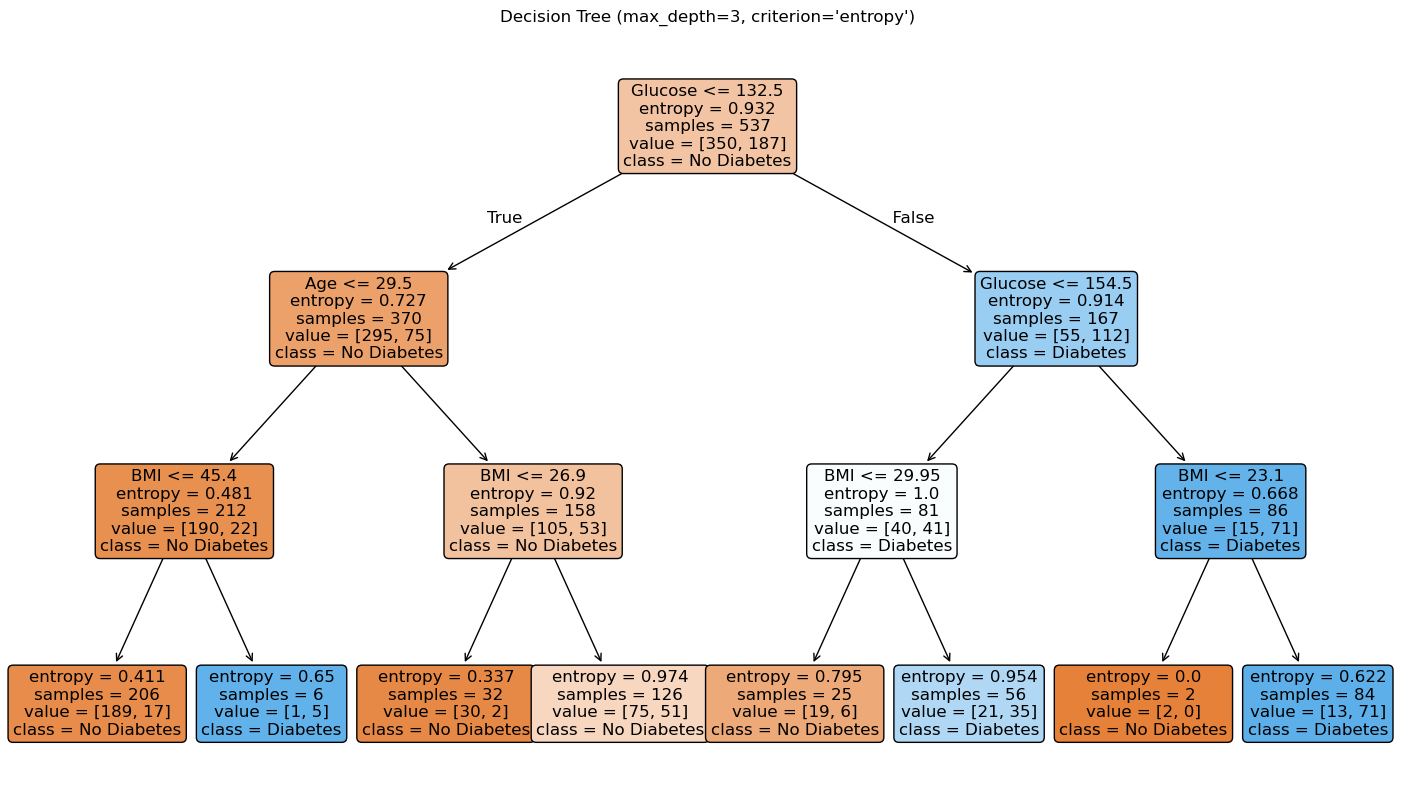

|--- Glucose <= 132.50
|   |--- Age <= 29.50
|   |   |--- BMI <= 45.40
|   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- class: 1
|   |--- Age >  29.50
|   |   |--- BMI <= 26.90
|   |   |   |--- class: 0
|   |   |--- BMI >  26.90
|   |   |   |--- class: 0
|--- Glucose >  132.50
|   |--- Glucose <= 154.50
|   |   |--- BMI <= 29.95
|   |   |   |--- class: 0
|   |   |--- BMI >  29.95
|   |   |   |--- class: 1
|   |--- Glucose >  154.50
|   |   |--- BMI <= 23.10
|   |   |   |--- class: 0
|   |   |--- BMI >  23.10
|   |   |   |--- class: 1



In [16]:
plt.figure(figsize=(18,10))
plot_tree(dtree, feature_names=features, class_names=['No Diabetes','Diabetes'],
          filled=True, rounded=True, fontsize=12)
plt.title("Decision Tree (max_depth=3, criterion='entropy')")
plt.show()

print(export_text(dtree, feature_names=list(features)))


## 6. Entropy, Information Gain, and Gini Index for Root Node

Let's calculate these for root node splitting.


In [18]:
tree_structure = export_text(dtree, feature_names=list(features))
root_line = tree_structure.split('\n')[0]
root_feature = root_line.split('feature_')[-1].split()[0] if 'feature_' in root_line else root_line.split('class:')[0].strip().split(' <= ')[0]
print("Root node split feature (by scikit-learn):", root_feature)

def entropy(p):
    return -p*np.log2(p) - (1-p)*np.log2(1-p) if 0 < p < 1 else 0

def gini(p):
    return 2*p*(1-p)

p1 = y_train.mean()
parent_entropy = entropy(p1)
parent_gini = gini(p1)
print(f"Parent node (Outcome) entropy: {parent_entropy:.4f}")
print(f"Parent node (Outcome) Gini: {parent_gini:.4f}")


info = {}
for col in features:
    thresholds = sorted(X_train[col].unique())
    threshold = np.median(X_train[col])
    left_mask = X_train[col] <= threshold
    right_mask = ~left_mask
    y_left = y_train[left_mask]
    y_right = y_train[right_mask]
    p_left = y_left.mean() if len(y_left)>0 else 0
    p_right = y_right.mean() if len(y_right)>0 else 0
    w_left = len(y_left)/len(y_train)
    w_right = len(y_right)/len(y_train)
    # Entropy
    ent_l = entropy(p_left)
    ent_r = entropy(p_right)
    weighted_entropy = w_left*ent_l + w_right*ent_r
    info_gain = parent_entropy - weighted_entropy
    # Gini
    gin_l = gini(p_left)
    gin_r = gini(p_right)
    weighted_gini = w_left*gin_l + w_right*gin_r
    info[col] = {'entropy': weighted_entropy, 'info_gain': info_gain, 'gini': weighted_gini}
    
entropy_table = pd.DataFrame(info).T
entropy_table['info_gain'] = entropy_table['info_gain'].round(4)
entropy_table['entropy'] = entropy_table['entropy'].round(4)
entropy_table['gini'] = entropy_table['gini'].round(4)
display(entropy_table.sort_values('info_gain', ascending=False))

print("Column with maximum information gain (root node):")
print(entropy_table['info_gain'].idxmax())
print("This should match scikit-learn's root node split - may differ if tree-criteria/threshold are more sophisticated.")

Root node split feature (by scikit-learn): |--- Glucose
Parent node (Outcome) entropy: 0.9325
Parent node (Outcome) Gini: 0.4539


,entropy,info_gain,gini
Glucose,0.8226,0.1099,0.3870
Age,0.8781,0.0543,0.4202
BMI,0.8930,0.0395,0.4293
Pregnancies,0.9024,0.0301,0.4351
BloodPressure,0.9226,0.0099,0.4477
DiabetesPedigreeFunction,0.9242,0.0083,0.4487
SkinThickness,0.9260,0.0064,0.4499
Insulin,0.9324,0.0001,0.4539


Column with maximum information gain (root node):
Glucose
This should match scikit-learn's root node split - may differ if tree-criteria/threshold are more sophisticated.
